In [1]:
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
%run '/home/dpirvu/project/BH_triggered_VD/data/findSpectrum.py'

### Simulation Parameters 

In [4]:
nLat = 512
lenLat = 1000
lamb = 0.05
frac = 2.

spectrum = Spectrum(nLat, lenLat, lamb, frac)
xL, kL, knyq, dx, dk, invFTcoeffs, dirFTcoeffs = spectrum.getLattice()

phi0 = 1.
V0 = 1.
nTime = nLat
nSims = 100
nCols = 2
alpha = 8
dt = dx/alpha
dtout = dt*alpha

In [5]:
sim_location = lambda sim: '/gpfs/dpirvu/dilatonBH/test_sim'+str(sim)+'_fields.dat'
plot_location = '/home/dpirvu/project/dilaton_bh/plots/'
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

def extract_sim(nT, nL, sim):
    data = np.genfromtxt(sim_location(sim))
    simulation = [np.reshape(data[:,col], (nT, nL)) for col in range(nCols)]
    return np.asarray(simulation)

In [6]:
# Import data
w2bare = np.genfromtxt('./data/frequencies'+'_N'+str(nLat)+'_L'+str(int(lenLat))+'_lambda'+str('%.3f'%lamb)+'.txt')[1:]
mat = np.genfromtxt('./data/transfMatrix'+'_N'+str(nLat)+'_L'+str(int(lenLat))+'_lambda'+str('%.3f'%lamb)+'.txt')
transfMatrix = np.reshape(mat[2:],(int(mat[0]),int(mat[1]))); print(np.shape(transfMatrix))

(257, 512)


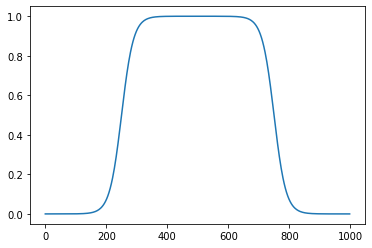

In [7]:
Ux = spectrum.Ux(lamb)
if True:
    plt.plot(xL, Ux)
    plt.show()

In [8]:
# Field power spectrum
norm = 1./ phi0 / np.sqrt(4. * lenLat)
w2free = lambda kL, m2: kL**2. + m2

# Free field (constant mass term) field modes \phi_k
free_eigenbasis = norm / w2free(kL, 1)**0.25
free_eigenbasis[kL==0]=0.

# Vacuum field
eigenbasis = norm / w2bare**0.25
eigenbasis[0]=0.
# Coordinate transformation of field modes \phi_k into momentum basis
spectral_field = np.dot(np.transpose(transfMatrix), eigenbasis)

#Compute full field \phi(x) as the inverse FT of the \phi_k's
free_field_fluctuations = np.tensordot(free_eigenbasis, np.exp(-1j*np.outer(xL, kL)), axes=(0,0))
field_fluctuations = np.tensordot(spectral_field, np.exp(-1j*np.outer(xL, kL)), axes=(0,0))

#Power spectrum of field in the BH background
pspec = np.abs(spectral_field)**2
fluct_variance = np.sum(pspec)

th_masses = lambda m2, lamb: m2 + 0.5 * lamb * fluct_variance
omega2_fit = lambda k, m2: k**2. + m2

In [9]:
all_data = np.asarray([extract_sim(nTime, nLat, sim) for sim in range(nSims)])
print('Done')
print(np.shape(all_data))

Done
(100, 2, 512, 512)


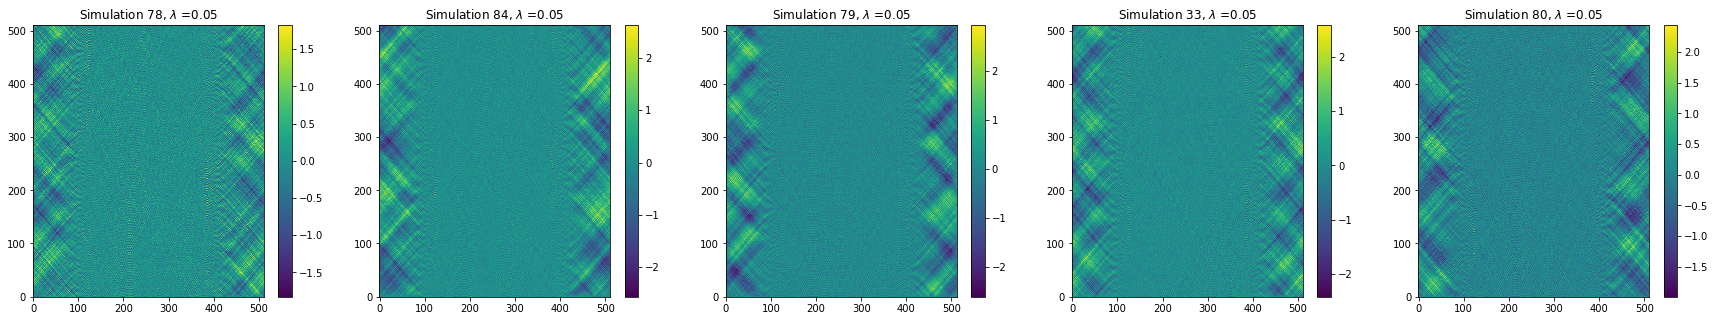

In [10]:
list_lambda = [lamb]
for lll, lamb in enumerate(list_lambda):
    list_sims = random.sample(range(nSims), 5)
#    list_sims = np.arange(0, 5, 1)

    fig, ax = plt.subplots(figsize = (6*len(list_sims), 5), ncols=len(list_sims))
    for s, sim in enumerate(list_sims):
        im0 = ax[s].imshow(all_data[sim][0], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[s])
        ax[s].set_title('Simulation '+str(sim)+r', $\lambda$ ='+str(lamb))
    plt.show()

In [11]:
intervals = np.asarray([2.*np.pi/dt/np.sqrt(i) for i in w2bare])
list_intervals = lambda i: np.asarray([y for y in [int(np.round(x*2.*np.pi/(dt*np.sqrt(w2bare[i])))) for x in range(1, nTime, 1)] if y < nTime])

In [12]:
if False:
#    print([np.mean(all_data[:, 0, time]) for time in range(0,nTime,30)])

    for sim in range(0, nSims, 10):
        fig, ax = plt.subplots(2, 1, figsize = (20, 5))
        [ax[0].plot(all_data[sim, 0, time]) for time in range(0,nTime,60)]
        [ax[1].plot(all_data[sim, 1, time]) for time in range(0,nTime,60)]
        plt.show()

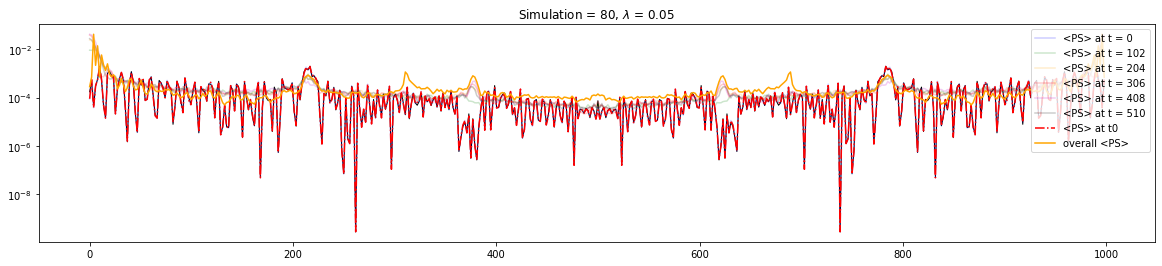

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (20,4))
colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))

th_field_PS = np.abs(spectral_field)**2.
plt.plot(xL, th_field_PS, linewidth=1, color='k')

for time in np.arange(0, nTime, 102):
    col=next(colors)
    averagePS_slice = np.mean(np.abs(np.fft.ifft(all_data[:,0,time]))**2., axis=0)
    plt.plot(xL, averagePS_slice, color=col, label='<PS> at t = '+str(time), alpha=0.2, ls='-')

averagePS_initialization = np.mean(np.abs(np.fft.ifft(all_data[:,0,0]))**2., axis=0)
plt.plot(xL, averagePS_initialization, color='red', label='<PS> at t0', alpha=1, ls='-.')

averagePS_fullpropagation = np.mean(np.abs(np.fft.ifft(all_data[:,0], axis=1))**2., axis=(0,2))
plt.plot(xL, averagePS_fullpropagation, color='orange', label='overall <PS>', alpha=1, ls='-')

plt.legend(loc='upper right')
plt.title(r'Simulation = '+str(sim)+r', $\lambda$ = '+str(lamb))
plt.axhline(0, ls='--', color='darkgray')
plt.yscale('log')
plt.show()

In [14]:
import scipy.signal as scs
import scipy.optimize as sco
from scipy.ndimage import gaussian_filter1d

def get_pspec(current_PS):
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(current_PS)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(current_PS)[0], d=dtout))*2*np.pi
    k_select = (kk>0.)
    o_select = (oo>0.)
    return current_PS[o_select][:, k_select], kk[k_select], oo[o_select]

def get_tri_pspec(current_data):
    fftfield = np.fft.fftshift(np.fft.ifft2(current_data[:,0]))
    PowSpec = np.mean(np.abs(fftfield)**2., axis=0)
    rePowSpec = np.mean(np.real(fftfield)**2., axis=0)
    imPowSpec = np.mean(np.imag(fftfield)**2., axis=0)
    listPS = [PowSpec, rePowSpec, imPowSpec]

    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
    k_select = (kk>0.)
    o_select = (oo>0.)
    return [[PowSpec[o_select][:, k_select], kk[k_select], oo[o_select]] for PowSpec in listPS]

def get_truncation_frequency(PowSpec):
    PowSpec, oo, kk = get_pspec(PowSpec)
    window_in_k = np.mean(PowSpec, axis=0)
    window_in_k = gaussian_filter1d(window_in_k, 1, mode='reflect')
    minpeaks, _ = scs.find_peaks(-window_in_k, height=-max(window_in_k))
    maxpeaks,_ = scs.find_peaks(window_in_k, height=window_in_k[len(kk)//4])

    # basically try to see if there are any walls, or if the PS is scrictly ascending at low k
    if window_in_k[0] < np.max(window_in_k):
        peak = minpeaks[0]
    else:
        peak = maxpeaks[1]

#    plt.plot(kk, window_in_k)
#    plt.plot(kk[peak], window_in_k[peak], 'o')
#    plt.xlim((-0.005, 2))
#    plt.yscale('log')
    return [PowSpec, peak, window_in_k[peak]]

In [15]:
def get_masses_seps(data, bool, multiplier):
        fftfield = np.fft.fftshift(np.fft.ifft2(data[:,0]))
        PowSpec = np.mean(np.abs(fftfield)**2., axis=0)
        rePowSpec = np.mean(np.real(fftfield)**2., axis=0)
        imPowSpec = np.mean(np.imag(fftfield)**2., axis=0)
        
        T, N = np.shape(PowSpec)
        kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
        kk = kk[kk>0.]
        oo = oo[oo>0.]
        KK, OO = np.meshgrid(kk,oo)

        infl_PowSpec, freqTrunc_PowSpec, ampFit_PowSpec = get_truncation_frequency(PowSpec)
        infl_rePowSpec, freqTrunc_rePowSpec, ampFit_rePowSpec = get_truncation_frequency(rePowSpec)
        infl_imPowSpec, freqTrunc_imPowSpec, ampFit_imPowSpec = get_truncation_frequency(imPowSpec)
        PS2plot = [infl_PowSpec, infl_rePowSpec, infl_imPowSpec]
        
        fullosccoords = np.argwhere(infl_PowSpec > multiplier*ampFit_PowSpec)
        reosccoords = np.argwhere(infl_rePowSpec > multiplier*ampFit_rePowSpec)
        imosccoords = np.argwhere(infl_imPowSpec > multiplier*ampFit_imPowSpec)
        coords2plot = np.asarray([fullosccoords, reosccoords, imosccoords])

        fullmass = sco.curve_fit(omega2_fit, kk[fullosccoords[:,1]], oo[fullosccoords[:,0]]**2.)[0]
        remass = sco.curve_fit(omega2_fit, kk[reosccoords[:,1]], oo[reosccoords[:,0]]**2.)[0]
        immass = sco.curve_fit(omega2_fit, kk[imosccoords[:,1]], oo[imosccoords[:,0]]**2.)[0]
        masses2plot = np.asarray([fullmass, remass, immass])
        
        title = ['Full, ', 'Real, ', 'Imag, ']
        if bool:
            fig, ax = plt.subplots(1, len(masses2plot), figsize = (20, 4))
            for iii, masses in enumerate(masses2plot):
                lim = 10
                k_select = (kk>0.)&(kk<=lim)
                o_select = (oo>0.)&(oo<=lim)
                kk2plot = kk[k_select]
                oo2plot = oo[o_select]
                exts = [kk2plot[0], kk2plot[-1], oo2plot[0], oo2plot[-1]]

                powspec2plot = PS2plot[iii][o_select][:, k_select]
                
                ax[iii].plot(kk[coords2plot[iii][:,1]], oo[coords2plot[iii][:,0]], 'o', ms=5)
#                if masses[-1] > 0.:
#                    ax[iii].plot(kk, np.sqrt(omega2_fit(kk,masses[-1])), color = 'r', linestyle=':', label=f'$m^2av = %5.2f$'%(masses[-1]))
#                else:
#                    print('Fitted mass is negative; adjust multiplier.')
                ax[iii].plot(kk, np.sqrt(kk**2.+1.), color = 'r', linestyle=':', label=f'$mPS^2 = %5.2f$'%(1.))
                ax[iii].plot(kk, np.sqrt(kk**2.+0.), color = 'r', linestyle=':', label=f'$mPS^2 = %5.2f$'%(0.))
                im = ax[iii].imshow(np.log(powspec2plot), aspect='auto', interpolation='none', origin='lower', extent=exts)
                clb = plt.colorbar(im, ax = ax[iii])
                clb.set_label(r'$\log{|\phi_k|^2}$')

            for opp in ax:
                opp.set_xlabel(r'$\bar{k}$')
                opp.set_ylabel(r'$\bar{\omega_k}$')
                opp.set_xlim(kk2plot[0], kk2plot[-1])
                opp.set_ylim(kk2plot[0], oo2plot[-1])
                opp.legend(title=r'$\lambda = %5.1f$'%(lamb), loc='lower right')
            plt.show()
        return masses2plot

In [16]:
# Make inverse coordinate transformation from position basis into operator eigenbasis
if False:
    for n in range(10):
        unit_vector = np.asarray([0. if x!=n else 1. for x in range(knyq)])
        position_vector = np.dot(np.transpose(transfMatrix), unit_vector)
#        plt.plot(xlist, tM[n]-np.dot(np.transpose(transfMatrix), unit_vector), ls=':')
        plt.plot(unit_vector-np.dot(transfMatrix, position_vector), ls=':')
        plt.show()

/cm/shared/apps/conda-environments/python39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


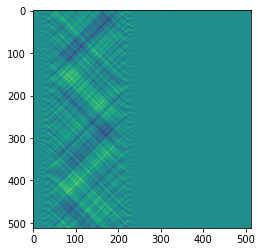

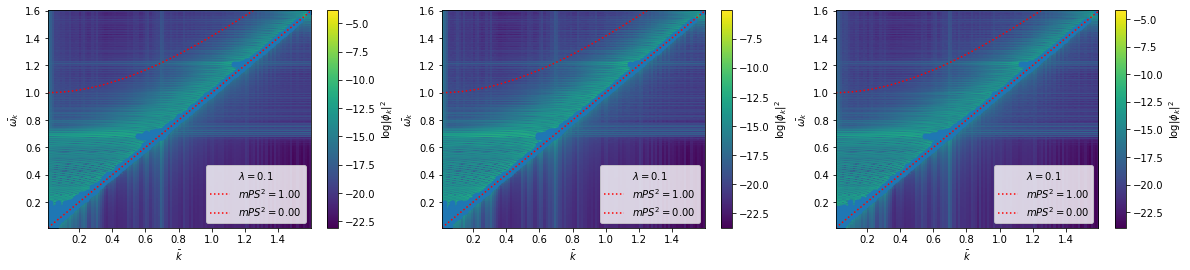

/cm/shared/apps/conda-environments/python39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


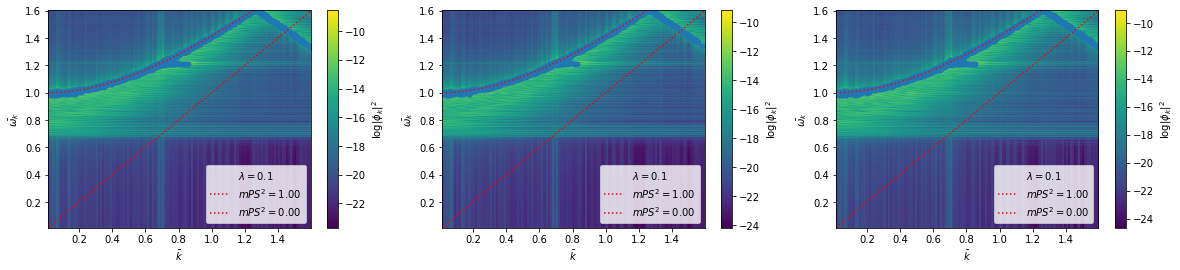

In [18]:
# Rotating along the x-axis to get dispersion relation for different regions
plt.imshow(np.roll(all_data, nLat//4, axis=-1)[0,0])

multiplier = 10.
# On the left hand side of the simulation is the field with dispersion relation where m^2(x) is zero.
allMasses = get_masses_seps(np.roll(all_data, nLat//4, axis=-1)[:,:,:,:nLat//2], True, multiplier)
# On the right hand side of the simulation is the field with dispersion relation where m^2(x) == 1.
allMasses = get_masses_seps(np.roll(all_data, nLat//4, axis=-1)[:,:,:,nLat//2:], True, multiplier)

#This is as is shoud be: where the Omega(x) factor (eq 2.7 in the Sergey paper) is zero,
# the effective field mass is zero, and the bubble nucleates towards the horizon;
# Meanwhile, where the effective field mass is 1., the field is asymptotically free

In [19]:
# The following is not yet functional
# This should be a coordinate transformation from tortoise coordinates (used in code) onto Cartesian coordinates

def tortoise_to_cartesian(field, lamb, dbhmass):
    rcart = lambda lamb, dbhmass, x: np.log( dbhmass * (np.exp(2.*lamb*x)+1.) /2./lamb ) /2./lamb
    xtort = lambda lamb, dbhmass, r: np.log( np.exp(2.*lamb*r) - dbhmass/2./lamb ) /2./lamb - np.log(dbhmass / 2./lamb) /2./lamb

    T, N = np.shape(field)
    x = np.arange(N)
    rr = rcart(lamb, dbhmass, x)
    xx = xtort(lamb, dbhmass, rr)
    cart_field = []
    for t in range(T):
        f = scp.interpolate.interp1d(x, field[t], kind='cubic')
        phix = scp.interpolate.splrep(x, f(x))
        phir = scp.interpolate.splev(xx, phix)
        cart_field.append(phir[np.isfinite(phir)])
#        if t%100 == 0:
#            plt.plot(field[t])
#            plt.plot(phir)
#            plt.show()
    return np.asarray(cart_field), rr[rr<1e308]

if False:
    for lll, lamb in enumerate(list_lambda):
        tortoise_field = np.mean([all_data[lll][sim][0] for sim in range(nSims)], axis=0)
        cartesian_field, rr = tortoise_to_cartesian(tortoise_field, lamb, 10)

        fig, ax = plt.subplots(1, 3, figsize = (12,5))
        im = ax[0].imshow(tortoise_field[:,:len(cartesian_field[0])], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im, ax = ax[0])
        im = ax[1].imshow(cartesian_field, aspect='auto', interpolation='none', origin='lower', extent=[min(rr), max(rr), 0, len(cartesian_field)-1])
        clb = plt.colorbar(im, ax = ax[1])
        im = ax[2].imshow(tortoise_field[:,:len(cartesian_field[0])]-cartesian_field, aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im, ax = ax[2])
        ax[0].set_title('original')
        ax[1].set_title('transformed')
        ax[2].set_title('difference')
        plt.show()